<a href="https://colab.research.google.com/github/carol-furtado/Denoising-and-image-classification/blob/main/Image_Denoising_%26_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [3]:
from google.colab import files
uploaded = files.upload()


Saving train.zip to train (1).zip


In [4]:
import zipfile

with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall("train")


In [5]:
!ls /content


 sample_data   train  'train (1).zip'   train.zip


In [6]:
data_dir_clean = "/content/train/train/clean"
data_dir_noisy = "/content/train/train/noisy"
normalization_layer = tf.keras.layers.Rescaling(1./255)

clean = tf.keras.utils.image_dataset_from_directory(
    data_dir_clean,
    labels=None,

    image_size=(224,224),
    batch_size=32,
    shuffle=False
).map(lambda x: (normalization_layer(x)))


noisy = tf.keras.utils.image_dataset_from_directory(
    data_dir_noisy,
    labels=None,

    image_size=(224,224),
    batch_size=32,
    shuffle=False
).map(lambda x: (normalization_layer(x)))


Found 1795 files.
Found 1795 files.


In [7]:
import numpy as np

# Convert TF dataset to numpy array (no labels since label_mode=None)
def dataset_to_numpy(dataset):
    images = []
    for batch in dataset:
        images.append(batch.numpy())   # each batch is a tensor of shape (batch_size, h, w, c)
    return np.concatenate(images, axis=0)

# Example
clean_train_images = dataset_to_numpy(clean)
noisy_train_images = dataset_to_numpy(noisy)

print(clean_train_images.shape)
print(noisy_train_images.shape)


(1795, 224, 224, 3)
(1795, 224, 224, 3)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class ConvAutoencoder(Model):
    def __init__(self, latent_dim=128):
        super(ConvAutoencoder, self).__init__()


        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(224, 224, 3)),
            layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=2),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])


        self.decoder = tf.keras.Sequential([
            layers.Dense(14*14*256, activation='relu'),
            layers.Reshape((14, 14, 256)),
            layers.Conv2DTranspose(128, (3,3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(3, (3,3), strides=2, activation='sigmoid', padding='same')
        ])

    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded


In [9]:

import tensorflow.image as tfi

def psnr_metric(y_true, y_pred):
    return tfi.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tfi.ssim(y_true, y_pred, max_val=1.0)


In [10]:

#compile
autoencoder=ConvAutoencoder()
autoencoder.compile(
    optimizer='adam',
    loss='mse',
    metrics=[psnr_metric, ssim_metric]
)


In [11]:
history = autoencoder.fit(
    x=tf.convert_to_tensor(noisy_train_images, dtype=tf.float32),
    y=tf.convert_to_tensor(clean_train_images, dtype=tf.float32),
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 583s 13s/step - loss: 0.0897 - psnr_metric: 10.8556 - ssim_metric: 0.3303 - val_loss: 0.0740 - val_psnr_metric: 11.6781 - val_ssim_metric: 0.2873
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 562s 12s/step - loss: 0.0698 - psnr_metric: 12.0005 - ssim_metric: 0.3185 - val_loss: 0.0586 - val_psnr_metric: 12.7712 - val_ssim_metric: 0.3388
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 566s 13s/step - loss: 0.0530 - psnr_metric: 13.3186 - ssim_metric: 0.3566 - val_loss: 0.0486 - val_psnr_metric: 13.3913 - val_ssim_metric: 0.3012
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 623s 13s/step - loss: 0.0431 - psnr_metric: 14.1318 - ssim_metric: 0.3509 - val_loss: 0.0434 - val_psnr_metric: 13.9382 - val_ssim_metric: 0.3367
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 572s 12s/step - loss: 0.0387 - psnr_metric: 14.6113 - ssim_metric: 0.3784 - val_loss: 0.0405 - val_psnr_metric: 14.2398 - val_ssim_metric: 0.3500
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 608s 13s/step - loss: 0.0345 - psnr_metric

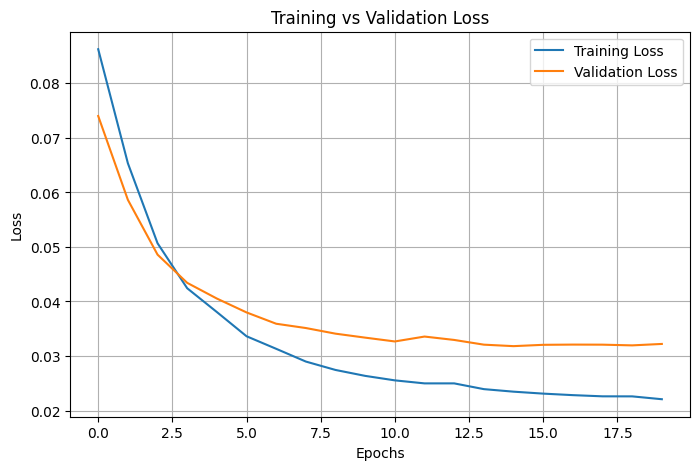

In [12]:
#plotting training vs validation loss
plt.figure(figsize=(8,5))

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()